# Models: Decision Tree, Random Forest

In [1]:
# Import relevant packages
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve, plot_precision_recall_curve
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from utils import process_data, compare_models, grid_search, get_gridsearch_results

In [2]:
data = process_data(type_ = 'normal')

Beginning data processing ...
Reading in batched data ...


100%|███████████████████████████████████████████| 19/19 [00:06<00:00,  2.79it/s]


Splitting data into train and test ...
Scaling data ...
Completed normal data processing.


In [3]:
X_train = data['X_train_scaled']
y_train = data['y_train']

X_test = data['X_test_scaled']
y_test = data['y_test']

## Useful Functions

In [4]:
def plot_roc_auc(clf):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    fpr, tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:, 1])
    auc_ = auc(fpr, tpr)

    ax1.plot([0, 1], [0, 1], '--')
    ax1.plot(fpr, tpr, label='area = {:.3f}'.format(auc_))
    ax1.set_xlabel('False positive rate')
    ax1.set_ylabel('True positive rate')
    ax1.set_title("Train ROC AUC")
    ax1.legend(loc='best')

    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    auc_ = auc(fpr, tpr)

    ax2.plot([0, 1], [0, 1], '--')
    ax2.plot(fpr, tpr, label='area = {:.3f}'.format(auc_))
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    ax2.set_title("Test ROC AUC")
    
    ax2.legend(loc='best')
    plt.show()

In [5]:
def plot_importances(clf):
    importances_impurity = clf.feature_importances_
    impurity_importances = pd.Series(importances_impurity).nlargest(10) 
    # select the 10 X variables with largest feature importance values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    impurity_importances.plot.bar(ax=ax1)
    ax1.set_title("Feature importances using MDI (mean decrease in impurity)")
    ax1.set_ylabel("Mean decrease in impurity")
    
    importances_permutation = permutation_importance(
        clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    permutation_importances = pd.Series(importances_permutation.importances_mean).nlargest(10)

    permutation_importances.plot.bar(ax=ax2)
    ax2.set_title("Feature importances using permutation importances")
    ax2.set_ylabel("Mean decrease in accuracy")
    fig.tight_layout()

# Decide which models to train

In [6]:
train_tree = False
train_rf = True

## Decision Tree Model

In [7]:
if train_tree:
    # Specify scoring criterion
    criterion = make_scorer(roc_auc_score, needs_proba=True)

    clf_tree = DecisionTreeClassifier()

    param_grid = dict(criterion=['gini', 'entropy'],
                      max_depth=[2, 5, 10],
                      ccp_alpha=[0, 0.00001, 0.0001])

    grid_result_tree = grid_search(clf_tree, criterion, param_grid, k=4, X=X_train, y=Y_train)
    
    # Choose best parameters from hyperparameter tuning
    clf_tree = grid_result_tree.best_estimator_
    
    # save best decision tree model
    pickle.dump(clf_tree, open('models/model_tree.sav', 'wb'))

In [8]:
if train_tree:
    get_gridsearch_results(grid_result_tree)

In [9]:
# read best decision tree model
clf_tree = pickle.load(open('models/model_tree.sav', 'rb'))

## Random Forest Model

In [10]:
if train_rf:
    # Specify scoring criterion
    criterion = make_scorer(roc_auc_score, needs_proba=True)

    clf_rf = RandomForestClassifier()

    param_grid = dict(criterion=['entropy'],
                      max_depth=[2, 5, 10],
                      ccp_alpha=[0, 1e-5, 1e-4],
                      n_estimators=[100, 150, 200]
                      )

    grid_result_rf = grid_search(clf_rf, criterion, param_grid, k=4, X=X_train, y=y_train)
    
    # Choose best parameters from hyperparameter tuning
    clf_rf = grid_result_rf.best_estimator_

    # save best decision tree model
    pickle.dump(clf_rf, open('models/model_rf.sav', 'wb'))

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[CV 1/4; 1/27] START ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=100
[CV 1/4; 1/27] END ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=100;, score=0.996 total time= 1.8min
[CV 2/4; 1/27] START ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=100
[CV 2/4; 1/27] END ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=100;, score=0.998 total time= 1.8min
[CV 3/4; 1/27] START ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=100
[CV 3/4; 1/27] END ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=100;, score=0.996 total time= 1.7min
[CV 4/4; 1/27] START ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=100
[CV 4/4; 1/27] END ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=100;, score=0.996 total time= 1.8min
[CV 1/4; 2/27] START ccp_alpha=0, criterion=entropy, max_depth=2, n_estimators=150
[CV 1/4; 2/27] END ccp_alpha=0, criterion=entropy, max_depth=2, n_e

[CV 2/4; 11/27] END ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=150;, score=0.998 total time= 2.8min
[CV 3/4; 11/27] START ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=150
[CV 3/4; 11/27] END ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=150;, score=0.995 total time= 2.9min
[CV 4/4; 11/27] START ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=150
[CV 4/4; 11/27] END ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=150;, score=0.997 total time= 3.0min
[CV 1/4; 12/27] START ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=200
[CV 1/4; 12/27] END ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=200;, score=0.997 total time= 3.9min
[CV 2/4; 12/27] START ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=200
[CV 2/4; 12/27] END ccp_alpha=1e-05, criterion=entropy, max_depth=2, n_estimators=200;, score=0.998 total time= 4.0min
[CV 3/4; 12/27] START ccp_alpha=1e-05, criterion=entr

[CV 2/4; 21/27] END ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=200;, score=0.998 total time= 3.8min
[CV 3/4; 21/27] START ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=200
[CV 3/4; 21/27] END ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=200;, score=0.996 total time= 3.8min
[CV 4/4; 21/27] START ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=200
[CV 4/4; 21/27] END ccp_alpha=0.0001, criterion=entropy, max_depth=2, n_estimators=200;, score=0.996 total time= 3.9min
[CV 1/4; 22/27] START ccp_alpha=0.0001, criterion=entropy, max_depth=5, n_estimators=100
[CV 1/4; 22/27] END ccp_alpha=0.0001, criterion=entropy, max_depth=5, n_estimators=100;, score=0.996 total time= 3.5min
[CV 2/4; 22/27] START ccp_alpha=0.0001, criterion=entropy, max_depth=5, n_estimators=100
[CV 2/4; 22/27] END ccp_alpha=0.0001, criterion=entropy, max_depth=5, n_estimators=100;, score=0.998 total time= 3.8min
[CV 3/4; 22/27] START ccp_alpha=0.0001, crit

In [11]:
if train_rf:
    get_gridsearch_results(grid_result_rf)

In [12]:
# read best decision rf model
clf_rf = pickle.load(open('models/model_rf.sav', 'rb'))

## Compare Models

In [13]:
clfs = [clf_tree, clf_rf]
clf_names = ['decision_tree', 'random_forest']

In [14]:
compare_models(clfs, clf_names, X_train, y_train, X_test, y_test)

,decision_tree,random_forest
accuracy_train,0.999994,0.999944
recall_train,0.993394,0.933526
precision_train,0.999585,1.000000
roc_auc_train,0.998185,0.998384
accuracy_test,0.999990,0.999936
recall_test,0.991749,0.925743
precision_test,0.996683,0.998221
roc_auc_test,0.997380,0.998015


Getting results for decision_tree model


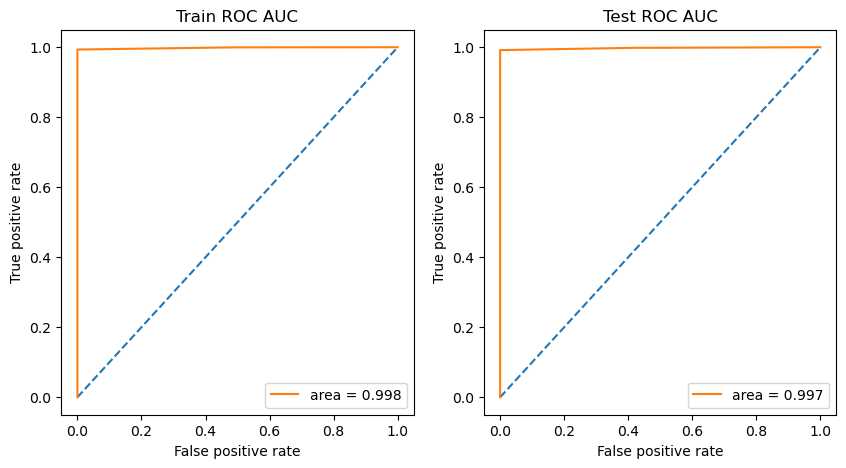

Getting results for random_forest model


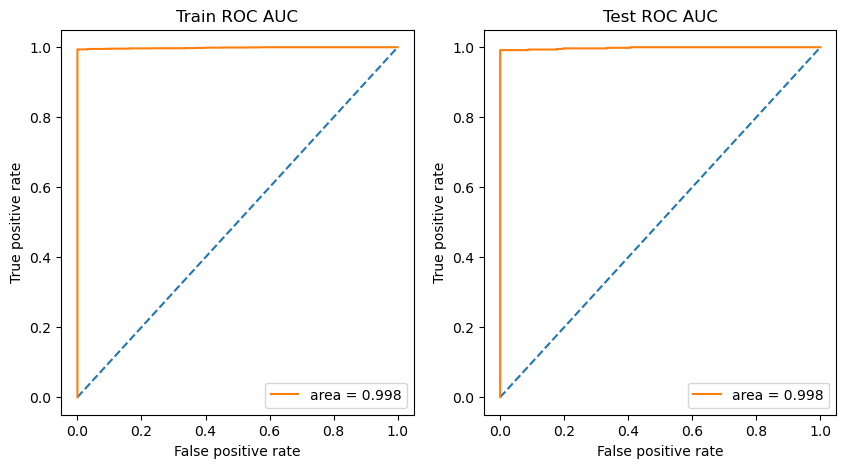

In [15]:
# Get plots
for i in range(len(clfs)):
    clf = clfs[i]
    print(f"Getting results for {clf_names[i]} model")
    plot_roc_auc(clf)
#     plot_importances(clf)